# Evaluation

### Training Model (like we did in week 3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

def prepare_data_set(X, y_column):
    X = X.reset_index(drop=True)
    y = X[y_column].values
    del X[y_column]
    return X, y

df_train, y_train = prepare_data_set(df_train, 'churn')
df_val, y_val = prepare_data_set(df_val, 'churn')
df_test, y_test = prepare_data_set(df_test, 'churn')

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges',]
categorical = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
    'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

### Accuracy and Dummy Model

In [8]:
thresholds = np.linspace(0, 1, 21)
scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores.append(score)

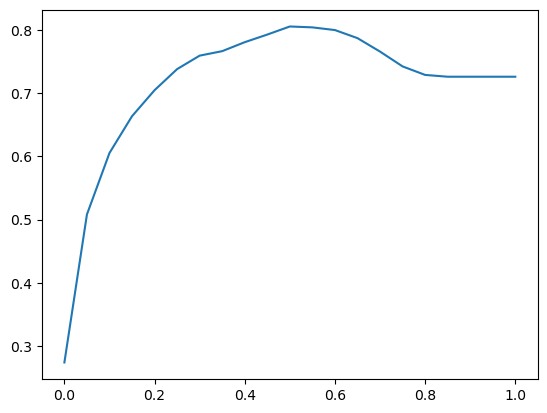

In [9]:
plt.plot(thresholds, scores)

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

### Confusion table

In [12]:
t = 0.5
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [13]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [14]:
tp, tn, fp, fn

(np.int64(212), np.int64(923), np.int64(100), np.int64(174))

In [15]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [174, 212]])

In [16]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

### Precision and Recall

In [17]:
precision = tp / (tp + fp)
precision

np.float64(0.6794871794871795)

In [18]:
recall = tp / (tp + fn)
recall

np.float64(0.5492227979274611)

### ROC curves

In [19]:
tpr = tp / (tp + fn)  # true positive rate (the same as recall)
fpr = fp / (fp + tn)  # false positive rate
tpr, fpr

(np.float64(0.5492227979274611), np.float64(0.09775171065493646))

In [20]:
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [21]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,537,19,486,0.950777,0.524927
20,0.2,337,367,49,656,0.873057,0.358749
30,0.3,292,245,94,778,0.756477,0.239492
40,0.4,252,175,134,848,0.652850,0.171065
50,0.5,212,100,174,923,0.549223,0.097752
60,0.6,155,51,231,972,0.401554,0.049853
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


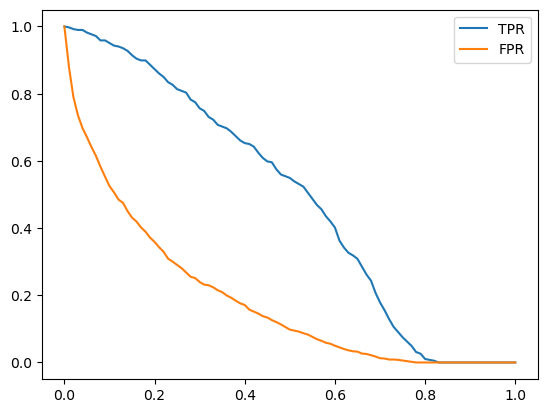

In [22]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

##### Random Model

In [23]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [24]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [25]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    return df_scores

In [26]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


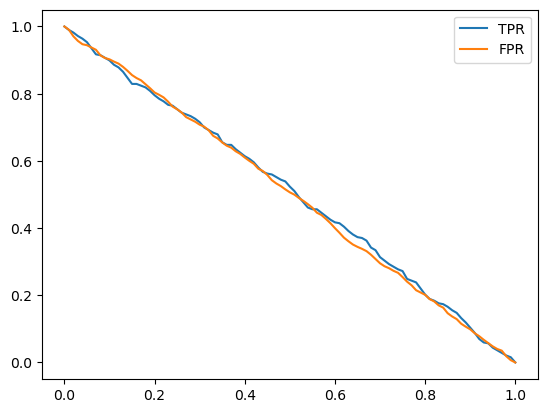

In [27]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

##### Ideal Model

In [28]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [29]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [30]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [31]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [32]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


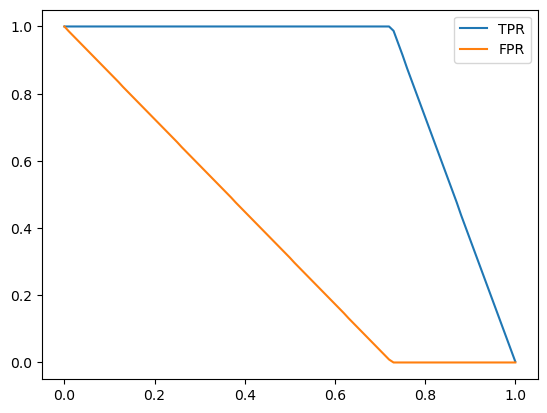

In [33]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

##### Putting everything together

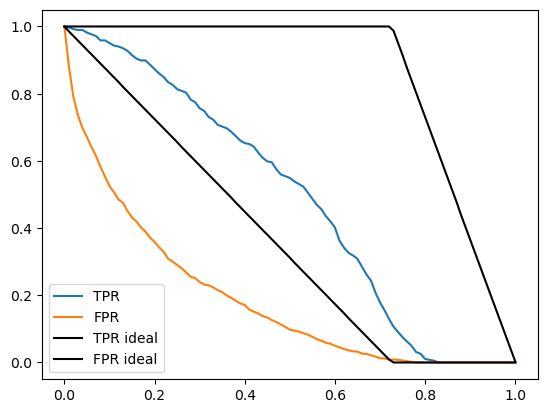

In [34]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR rand')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR rand')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR ideal', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR ideal', color='black')

plt.legend()

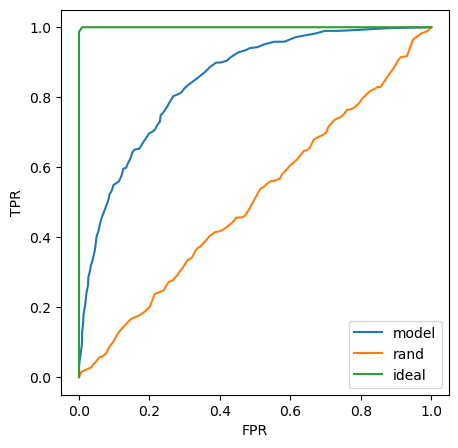

In [35]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='rand')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

##### Using scikit-learn

In [36]:
from sklearn.metrics import roc_curve

In [37]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

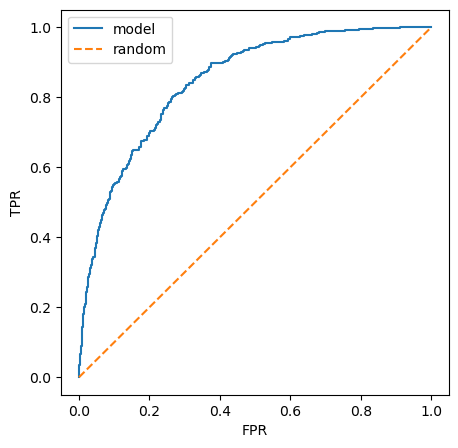

In [38]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### ROC AUC (Area Under the roc Curve)

In [39]:
from sklearn.metrics import auc

In [40]:
auc(fpr, tpr)

0.8465981898206534

In [41]:
auc(df_scores.fpr, df_scores.tpr)

0.8463208889834327

In [42]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [43]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8465981898206534

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(y_val, y_pred)

0.8465981898206534

In [46]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [47]:
import random

In [51]:
n = 100000
success = 0
for i in range(n):
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)
    if pos[pos_idx] > neg[neg_idx]:
        success += 1

success / n  # it's close to ROC AUC

0.84729

In [54]:
pos_idx = np.random.randint(0, len(pos), size=n)
neg_idx = np.random.randint(0, len(neg), size=n)

(pos[pos_idx] > neg[neg_idx]).mean()

np.float64(0.84666)

### Cross-Validation

In [71]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=1, C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [58]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [59]:
from sklearn.model_selection import KFold

In [60]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [69]:
!conda install tqdm -y

Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/koles/anaconda3/envs/machine-learning-zoomcamp-homework

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.67.1                |  py313h7040dfc_0         162 KB
    ------------------------------------------------------------
                                           Total:         162 KB

The following NEW packages will be INSTALLED:

  tqdm               pkgs/main/linux-64::tqdm-4.67.1-py313h7040dfc_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [70]:
from tqdm.auto import tqdm

In [75]:
for C in tqdm([0.000001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/8 [00:00<?, ?it/s]

1e-06 0.720 +- 0.035
0.001 0.826 +- 0.016
0.01 0.840 +- 0.012
0.1 0.842 +- 0.012
0.5 0.842 +- 0.012
1 0.842 +- 0.012
5 0.842 +- 0.012
10 0.842 +- 0.012


In [77]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8579400803839363